In [164]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from gplearn.genetic import SymbolicRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [2]:
plt.rcParams.update({'font.size': 16})

In [3]:
trn = xr.open_dataset('../foo/lores.nc')
tst = xr.open_dataset('../bar/lores.nc')
xfer = xr.open_dataset('../baz/lores.nc')

# Create a library of basis functions which are derivatives of various quantites

In [4]:
def augment_with_derivatives(ds):
    ds['u_x'] = ds.u.differentiate('x')
    ds['u_y'] = ds.u.differentiate('y')
    ds['v_x'] = ds.v.differentiate('x')
    ds['v_y'] = ds.v.differentiate('y')
    ds['u_xx'] = ds.u_x.differentiate('x')
    ds['u_xy'] = ds.u_x.differentiate('y')
    ds['u_yy'] = ds.u_y.differentiate('y')
    ds['v_xx'] = ds.v_x.differentiate('x')
    ds['v_xy'] = ds.v_x.differentiate('y')
    ds['v_yy'] = ds.v_y.differentiate('y')
    ds['q_x'] = ds.q.differentiate('x')
    ds['q_y'] = ds.q.differentiate('y')
    ds['q_xx'] = ds.q_x.differentiate('x')
    ds['q_yy'] = ds.q_y.differentiate('y')
    ds['q_xy'] = ds.q_x.differentiate('y')
    ds['dqdt_x'] = ds.dqdt.differentiate('x')
    ds['dqdt_y'] = ds.dqdt.differentiate('y')
    ds['dqdt_xx'] = ds.dqdt_x.differentiate('x')
    ds['dqdt_xy'] = ds.dqdt_x.differentiate('y')
    ds['dqdt_yy'] = ds.dqdt_y.differentiate('y')
    return ds

for ds in [trn, tst, xfer]:
    augment_with_derivatives(ds)

# Goal will be to predict our two versions of subgrid forcing in the upper layer based on our features in both layers

In [7]:
Y1 = trn.isel(lev=0).q_forcing_advection.data.ravel()
Y1_sd = np.std(Y1)
Y1 = Y1 / Y1_sd

Y2 = trn.isel(lev=0).q_forcing_model.data.ravel()
Y2_sd = np.std(Y2)
Y2 = Y2 / Y2_sd

In [5]:
feats = ['q','q_x','q_y','q_xx','q_xy','q_yy','dqdt','dqdt_x','dqdt_y','dqdt_xx','dqdt_xy','dqdt_yy','u','v','u_x','u_y','v_x','v_y',
        'u_xx','u_xy','u_yy','v_xx','v_xy','v_yy']
feature_names = [f+'1'for f in feats]+[f+'2'for f in feats]

X = np.array([
    trn.isel(lev=0)[feat].data.ravel()
    for feat in feats
] + [
    trn.isel(lev=1)[feat].data.ravel()
    for feat in feats
]).T

X_scale = StandardScaler()
X = X_scale.fit_transform(X)

X.shape

(356352, 48)

In [314]:
Y1_test = tst.isel(lev=0).q_forcing_advection.data.ravel()
Y1_test = Y1_test / Y1_sd

Y2_test = tst.isel(lev=0).q_forcing_model.data.ravel()
Y2_test = Y2_test / Y2_sd

X_test = np.array([
    tst.isel(lev=0)[feat].data.ravel()
    for feat in feats
] + [
    tst.isel(lev=1)[feat].data.ravel()
    for feat in feats
]).T

X_test = X_scale.fit_transform(X_test)

X_test.shape

(356352, 48)

In [325]:
Y1_xfer = xfer.isel(lev=0).q_forcing_advection.data.ravel()
Y1_xfer = Y1_xfer / Y1_sd

Y2_xfer = xfer.isel(lev=0).q_forcing_model.data.ravel()
Y2_xfer = Y2_xfer / Y2_sd

X_xfer = np.array([
    xfer.isel(lev=0)[feat].data.ravel()
    for feat in feats
] + [
    xfer.isel(lev=1)[feat].data.ravel()
    for feat in feats
]).T

X_xfer = X_scale.fit_transform(X_xfer)

X_xfer.shape

(356352, 48)

# Run linear regression and Lasso baselines (not combining any symbols)

In [326]:
lr1 = LinearRegression()
lr1.fit(X, Y1)
lr1.score(X, Y1), lr1.score(X_test, Y1_test), lr1.score(X_xfer, Y1_xfer)

(0.6321513069696011, 0.6378664934374607, -0.5805954774122069)

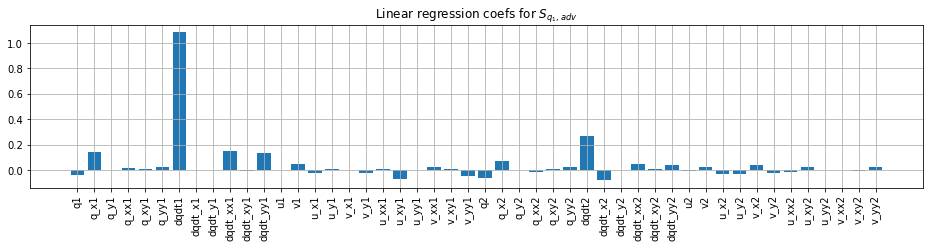

In [317]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X.shape[1]), lr1.coef_)
plt.xticks(np.arange(X.shape[1]), feature_names, rotation=90)
plt.grid()
plt.title("Linear regression coefs for $S_{q_1,adv}$")
plt.show()

In [327]:
lr2 = LinearRegression()
lr2.fit(X, Y2)
lr2.score(X, Y2), lr2.score(X_test, Y2_test), lr2.score(X_xfer, Y2_xfer)

(0.04684972360750084, 0.047514253623072045, -0.06925691709286519)

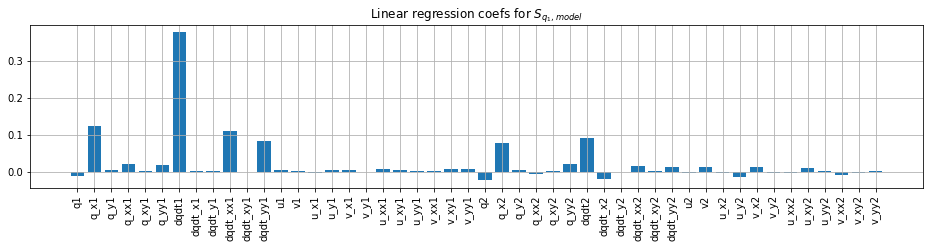

In [319]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X.shape[1]), lr2.coef_)
plt.xticks(np.arange(X.shape[1]), feature_names, rotation=90)
plt.grid()
plt.title("Linear regression coefs for $S_{q_1,model}$")
plt.show()

In [320]:
ted1 = Lasso(alpha=0.05)
ted1.fit(X, Y1)
ted1.score(X, Y1), ted1.score(X_test, Y1_test), ted1.score(X_xfer, Y1_xfer)

(0.5963998889802196, 0.5989884160658678, -0.1666504516968299)

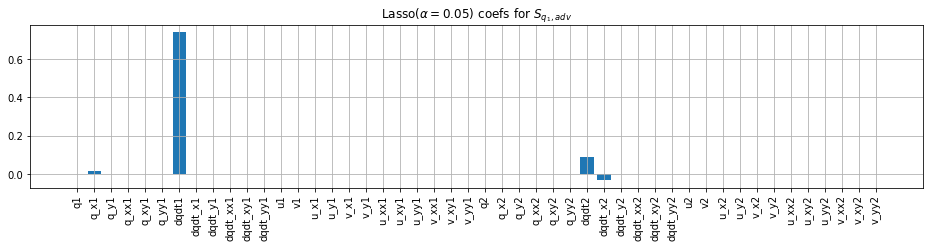

In [321]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X.shape[1]), ted1.coef_)
plt.xticks(np.arange(X.shape[1]), feature_names, rotation=90)
plt.grid()
plt.title("Lasso($\\alpha=0.05$) coefs for $S_{q_1,adv}$")
plt.show()

In [328]:
ted2 = Lasso(alpha=0.05)
ted2.fit(X, Y2)
ted2.score(X, Y2), ted2.score(X_test, Y2_test), ted2.score(X_xfer, Y2_xfer)

(0.027675917656226123, 0.02805660995060988, 0.009649380963801968)

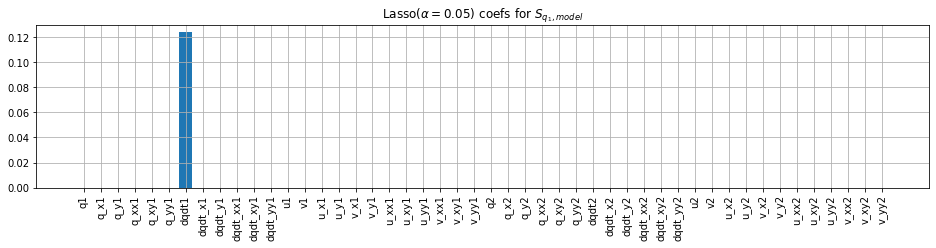

In [323]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X.shape[1]), ted2.coef_)
plt.xticks(np.arange(X.shape[1]), feature_names, rotation=90)
plt.grid()
plt.title("Lasso($\\alpha=0.05$) coefs for $S_{q_1,model}$")
plt.show()

# Run neural network baseline (= as well as we can expect symbolic regression to do from the same inputs)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('..')
from models import train

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(X.shape[1], 100)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x
    
net = Net()
train(net,X,Y1.reshape(-1,1),num_epochs=20)

Loss after Epoch 1: 0.3069216539459731
Loss after Epoch 2: 0.25244148095250774
Loss after Epoch 3: 0.24218191693660043
Loss after Epoch 4: 0.2342142108399635
Loss after Epoch 5: 0.22787928412903913
Loss after Epoch 6: 0.22201080280075106
Loss after Epoch 7: 0.2167314807884395
Loss after Epoch 8: 0.21164514274261464
Loss after Epoch 9: 0.20853481514228175
Loss after Epoch 10: 0.20533636856379908
Loss after Epoch 11: 0.18651253272492932
Loss after Epoch 12: 0.18338855499490003
Loss after Epoch 13: 0.1822215685582099
Loss after Epoch 14: 0.18129918005132792
Loss after Epoch 15: 0.18070339374364644
Loss after Epoch 16: 0.17810009617389222
Loss after Epoch 17: 0.1778302405861838
Loss after Epoch 18: 0.1774905071394443
Loss after Epoch 19: 0.17746329890168006
Loss after Epoch 20: 0.1774494287747911


In [19]:
from sklearn.metrics import r2_score

In [324]:
Y1_pred = net(torch.as_tensor(X)).detach().numpy()
Y1_pred_test = net(torch.as_tensor(X_test)).detach().numpy()
Y1_pred_xfer = net(torch.as_tensor(X_xfer)).detach().numpy()
r2_score(Y1,Y1_pred), r2_score(Y1_test,Y1_pred_test), r2_score(Y1_xfer,Y1_pred_xfer)

(0.8225954717058394, 0.8035548626942688, -0.8956800264105169)

Unsurprisingly, the NN does much better than linear regression at predicting the advection version of subgrid forcing. However, it fails to transfer to the jet configuration. Still, let's investigate what it learned.

In [21]:
import torch.autograd as autograd

X_grad = torch.as_tensor(X).requires_grad_()
Y_grad = net(X_grad)
dy_dx = autograd.grad(Y_grad.sum(), X_grad)[0].detach().numpy()

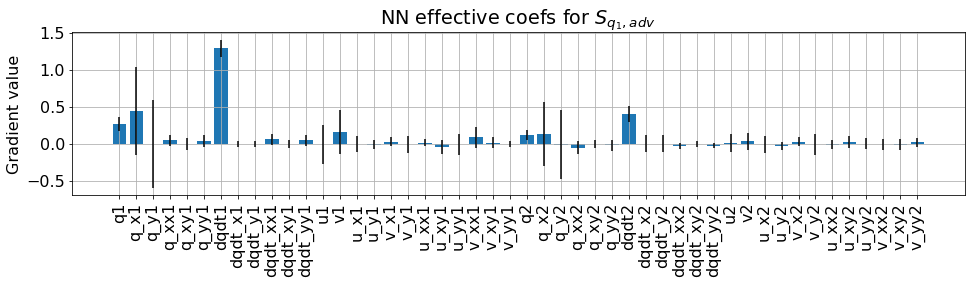

In [22]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X.shape[1]), dy_dx.mean(axis=0), yerr=dy_dx.std(axis=0))
plt.xticks(np.arange(X.shape[1]), feature_names, rotation=90)
plt.grid()
plt.title("NN effective coefs for $S_{q_1,adv}$")
plt.ylabel("Gradient value")
plt.show()

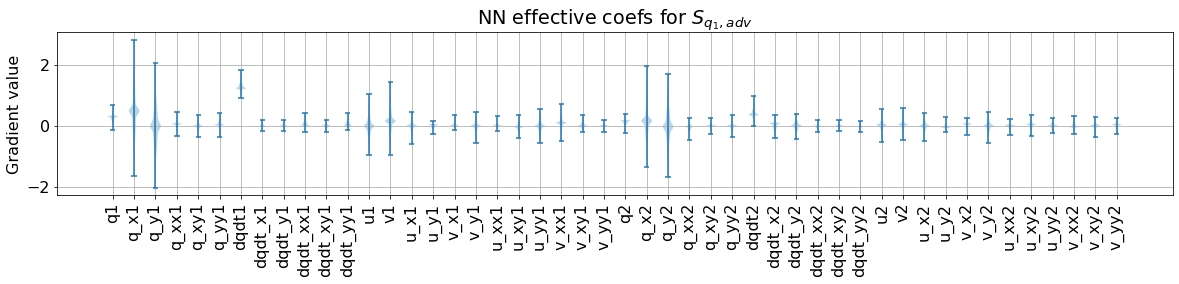

In [23]:
order = np.arange(len(dy_dx))
np.random.shuffle(order)
plt.figure(figsize=(20,3))
plt.violinplot(dy_dx[order[:10000]])
plt.grid()
plt.xticks(np.arange(X.shape[1])+1, feature_names, rotation=90)
plt.title("NN effective coefs for $S_{q_1,adv}$")
plt.ylabel("Gradient value")
plt.show()

In [138]:
important_feats = list(np.argwhere(np.abs(dy_dx).mean(axis=0) > 0.1)[:,0])
print("Important features:")
print([feature_names[i] for i in important_feats])

Important features:
['q1', 'q_x1', 'q_y1', 'dqdt1', 'u1', 'v1', 'u_yy1', 'v_xx1', 'q2', 'q_x2', 'q_y2', 'dqdt2']


For predicting this version of the upper layer's subgrid forcing, it looks like the relevant features are the potential vorticity plus its spatial and time derivatives at both layers, as well as the velocity in the upper layer. It might make sense to initialize symbolic regression with those terms.

But how should symbolic regression combine these terms? Let's investigate with a quick second-order test:

In [57]:
baseline = Y1_pred

dx = 0.01

perturbed_fs = {}

for f in range(len(feature_names)):
    df = np.zeros_like(X)
    df[:,f] = dx
    perturbed_fs[f] = (baseline - net(torch.as_tensor(X + df)).detach().numpy())

In [58]:
doubly_perturbed_fs = {}

for f1 in range(len(feature_names)):
    for f2 in range(len(feature_names)):
        df12 = np.zeros_like(X)
        df12[:,f1] += dx
        df12[:,f2] += dx
        doubly_perturbed_fs[(f1,f2)] = (baseline - net(torch.as_tensor(X + df12)).detach().numpy())

In [59]:
second_diffs = np.array([[
    np.abs(doubly_perturbed_fs[(i,j)] - perturbed_fs[i] - perturbed_fs[j]).mean()
    for i in range(len(feature_names))] for j in range(len(feature_names))
])

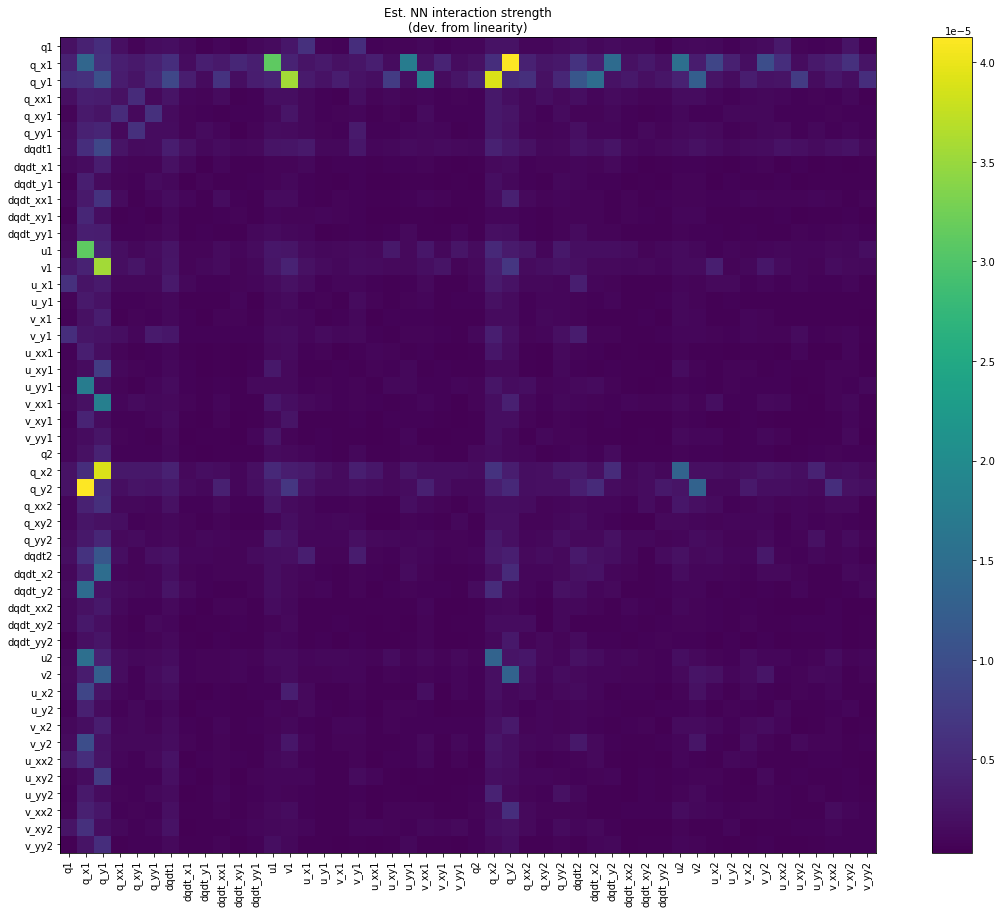

In [237]:
plt.figure(figsize=(20,15))
plt.title("Est. NN interaction strength\n(dev. from linearity)")
plt.imshow(second_diffs)
plt.yticks(range(len(feature_names)), feature_names)
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.colorbar()
plt.show()

In [236]:
interactions = []
for i,j in np.argwhere((second_diffs > np.percentile(second_diffs, 98))):
    if i > j:
        interactions.append(f"{second_diffs[j,i]:.6f}: {feature_names[i]}, {feature_names[j]}")
print("Important interactions:")
for i in sorted(interactions, reverse=True):
    print(i)

Important interactions:
0.000041: q_y2, q_x1
0.000039: q_x2, q_y1
0.000036: v1, q_y1
0.000031: u1, q_x1
0.000018: v_xx1, q_y1
0.000018: u_yy1, q_x1
0.000015: u2, q_x1
0.000015: dqdt_y2, q_x1
0.000015: dqdt_x2, q_y1
0.000013: v2, q_y2
0.000013: v2, q_y1
0.000013: u2, q_x2
0.000011: dqdt2, q_y1
0.000010: v_y2, q_x1
0.000009: u_x2, q_x1
0.000009: dqdt1, q_y1
0.000007: u_xy2, q_y1
0.000007: u_xy1, q_y1
0.000007: q_y2, v1
0.000006: q_y1, q_x1
0.000006: dqdt_xx1, q_y1
0.000006: dqdt2, q_x1


A very rudimentary analysis of how the neural network is combining these terms suggests interactions between x/y-velocity and the x/y derivatives of $q$, as well as between the x/y-derivative of $q_1$ and the alternate y/x-derivatives of $q_2$.

In [294]:
def extract_important_X(df, scale=None):
    names = [feature_names[f] for f in important_feats] + [
        '$(u_1 \\cdot \\nabla)q_1$',
        '$(u_2 \\cdot \\nabla)q_2$',
        '$J(q_1, q_2)$',
        'q_x1 dqdt_y2',
        'q_y1 dqdt_x2',
        'q_x1 u_yy1',
        'q_y1 v_xx1',
        '$\\nabla \\cdot \\nabla \\frac{\\partial q_1}{\\partial t}$',
        '$\\nabla \\cdot \\nabla \\frac{\\partial q_2}{\\partial t}$',
    ]
    
    X2 = [
        df[feature_names[f][:-1]].isel(lev=int(feature_names[f][-1])-1)
        for f in important_feats
    ] + [
        df['u'].isel(lev=0) * df['q_x'].isel(lev=0) + df['v'].isel(lev=0) * df['q_y'].isel(lev=0),
        df['u'].isel(lev=1) * df['q_x'].isel(lev=1) + df['v'].isel(lev=1) * df['q_y'].isel(lev=1),
        df['q_x'].isel(lev=0) * df['q_y'].isel(lev=1) - df['q_y'].isel(lev=0) * df['q_x'].isel(lev=1),
        df['q_x'].isel(lev=0) * df['dqdt_y'].isel(lev=1),
        df['q_y'].isel(lev=0) * df['dqdt_x'].isel(lev=1),
        
        df['q_x'].isel(lev=0) * df['u_yy'].isel(lev=0),
        df['q_y'].isel(lev=0) * df['v_xx'].isel(lev=0),
        
        (df['dqdt_xx']+df['dqdt_yy']).isel(lev=0),
        (df['dqdt_xx']+df['dqdt_yy']).isel(lev=1),
    ]
    
    X2 = np.array([x.data.ravel() for x in X2]).T

    if scale is None:
        scale = StandardScaler(with_mean=False)
        scale.fit(X2)
    
    return scale.transform(X2), names, scale

X2, names2, scale2 = extract_important_X(trn)
X2_test, _, __ = extract_important_X(tst, scale2)
X2_xfer, _, __ = extract_important_X(xfer, scale2)

In [259]:
lr1.score(X, Y1), lr1.score(X_test, Y1_test), lr1.score(X_xfer, Y1_xfer)

(0.6321513069696011, 0.6378664934374607, -0.5805954774122069)

In [295]:
lr3 = LinearRegression()
lr3.fit(X2, Y1)
lr3.score(X2, Y1), lr3.score(X2_test, Y1_test), lr3.score(X2_xfer, Y1_xfer)

(0.6910218604366947, 0.6955521603689261, 0.5365334718276138)

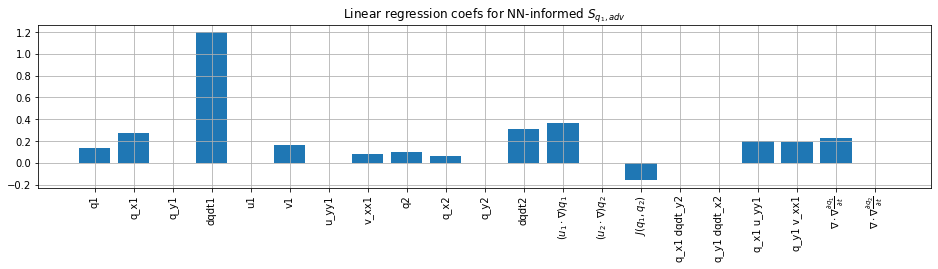

In [296]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X2.shape[1]), lr3.coef_)
plt.xticks(np.arange(X2.shape[1]), names2, rotation=90)
plt.grid()
plt.title("Linear regression coefs for NN-informed $S_{q_1,adv}$")
plt.show()

In [297]:
lr3 = Lasso(alpha=0.01)
lr3.fit(X2, Y1)
lr3.score(X2, Y1), lr3.score(X2_test, Y1_test), lr3.score(X2_xfer, Y1_xfer)

(0.6811258002142042, 0.6856629581239799, 0.5528320213472785)

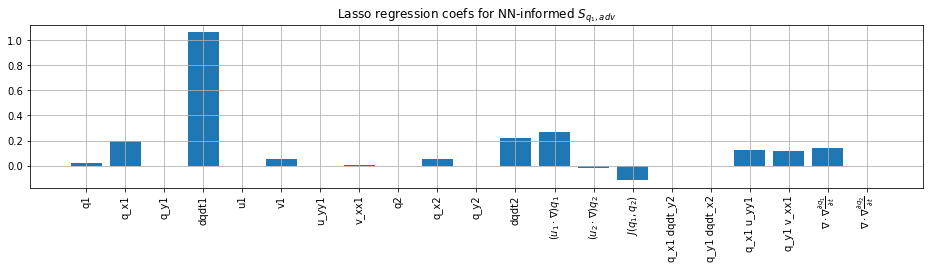

In [298]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X2.shape[1]), lr3.coef_)
plt.xticks(np.arange(X2.shape[1]), names2, rotation=90)
plt.grid()
plt.title("Lasso regression coefs for NN-informed $S_{q_1,adv}$")
plt.show()


In [312]:
big_lasso = np.argwhere(np.abs(lr3.coef_) > np.abs(lr3.coef_.max()) * 0.05)[:,0]
#big_lasso = np.argwhere(lr3.coef_ > lr3.coef_.max() * 0.05)[:,0]
lr4 = LinearRegression()
lr4.fit(X2[:,big_lasso], Y1)
lr4.score(X2[:,big_lasso], Y1), lr4.score(X2_test[:,big_lasso], Y1_test), lr4.score(X2_xfer[:,big_lasso], Y1_xfer)

(0.6825052233748058, 0.6869816409889862, 0.5804486960901656)

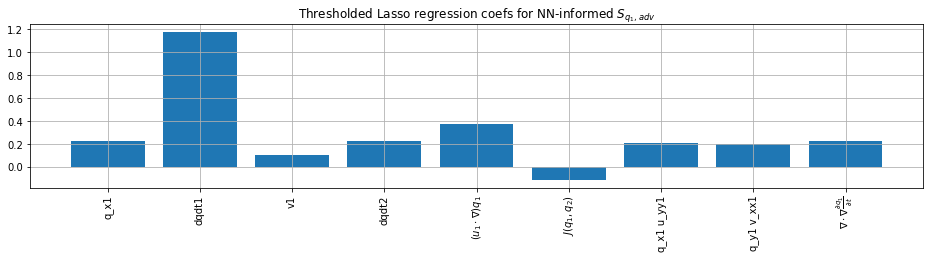

In [313]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(len(big_lasso)), lr4.coef_)
plt.xticks(np.arange(len(big_lasso)), [names2[i] for i in big_lasso], rotation=90)
plt.grid()
plt.title("Thresholded Lasso regression coefs for NN-informed $S_{q_1,adv}$")
plt.show()

So, this is pretty cool -- by analyzing our network's gradients and interaction terms, we were able to find a set of linear features that performs better than the initial linear model, and much better than every other model when transferring.

Ok, now let's try to predict our alternate version of subgrid forcing.

In [329]:
net2 = Net()
train(net2,X,Y2.reshape(-1,1),num_epochs=20)

Loss after Epoch 1: 0.935512413565155
Loss after Epoch 2: 0.9018282072415211
Loss after Epoch 3: 0.8928299917807353
Loss after Epoch 4: 0.887102621789465
Loss after Epoch 5: 0.8810120686786999
Loss after Epoch 6: 0.8754345222467278
Loss after Epoch 7: 0.8703930177404706
Loss after Epoch 8: 0.8646885293974788
Loss after Epoch 9: 0.8597232489311404
Loss after Epoch 10: 0.8561544136261974
Loss after Epoch 11: 0.8323014307895611
Loss after Epoch 12: 0.8274927773277393
Loss after Epoch 13: 0.8252338901263844
Loss after Epoch 14: 0.8235422118256489
Loss after Epoch 15: 0.8221280472513673
Loss after Epoch 16: 0.8184328274105558
Loss after Epoch 17: 0.8179302133309344
Loss after Epoch 18: 0.817400299438179
Loss after Epoch 19: 0.8173681681510061
Loss after Epoch 20: 0.8173430820969844


In [331]:
Y2_pred = net2(torch.as_tensor(X)).detach().numpy()
Y2_pred_test = net2(torch.as_tensor(X_test)).detach().numpy()
Y2_pred_xfer = net2(torch.as_tensor(X_xfer)).detach().numpy()
print("Train, Test, Transfer")
print(r2_score(Y2,Y2_pred), r2_score(Y2_test,Y2_pred_test), r2_score(Y2_xfer,Y2_pred_xfer))

Train, Test, Transfer
0.18272256562142286 0.15550839954619078 -0.4829385643281563


Interestingly, it looks like it's pretty hard to predict our alternate version of subgrid forcing using this method, even on our training set. For this, we'll probably need alternate features.

# Try nearest neighbors (for Joan)

In [91]:
from sklearn.neighbors import KNeighborsRegressor

knn1 = KNeighborsRegressor(n_neighbors=1)

order = np.arange(len(X))
np.random.shuffle(order)
knn1.fit(X[order[:50000]],Y1[order[:50000]])
knn1.score(X[order[:50000]],Y1[order[:50000]])

1.0

In [92]:
knn1.score(X_test[order[:50000]],Y1_test[order[:50000]])

0.08768421474522015

In [94]:
knn2 = KNeighborsRegressor(n_neighbors=1)
knn2.fit(X[order[:50000]],Y2[order[:50000]])
knn2.score(X[order[:50000]],Y2[order[:50000]])

1.0

In [95]:
knn2.score(X_test[order[:50000]],Y2_test[order[:50000]])

-9.724253445586584e-06

Nearest neighbors does not work well on the test set :(

# Try symbolic regression with genetic programming to combine terms

In [101]:
reg = SymbolicRegressor(feature_names=feature_names,
                        population_size=5000,
                        generations=20, stopping_criteria=0.01,
                        p_crossover=0.7, p_subtree_mutation=0.1,
                        p_hoist_mutation=0.05, p_point_mutation=0.1,
                        max_samples=0.9, verbose=1,
                        parsimony_coefficient=0.01, random_state=0)
reg.fit(X,Y1)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/opt/miniconda3/lib/python3.9/site-packages/gplearn/functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   0    25.75           384222        3         0.590163         0.591998     20.44m
   1     3.42          869.455        3         0.372905         0.374827     13.44m
   2     3.19          4.10542        3          0.37274         0.376306     13.02m
   3     1.61          2.04752        3         0.372386         0.379495     11.59m
   4     2.43          2.00931        3         0.371995         0.383019     12.39m
   5     3.26          4.38418        3         0.372069         0.382352     12.76m
   6     3.18          1.59018        3         0.372006         0.382913     11.91m
   7     3.25          212.964        3         0.371991         0.383047     11.00m
   8     3.23          3.72685        3          0.37214         0.381715     10.08m
   9     3.23          3.34588        3         0.371786         0.384895      9.21m
  10     3.19          2.89646        3         0.372002         0.382952      8.32m
  11     3.23          39.6525        3         0.372099         

SymbolicRegressor(feature_names=['q1', 'q_x1', 'q_y1', 'q_xx1', 'q_xy1',
                                 'q_yy1', 'dqdt1', 'dqdt_x1', 'dqdt_y1', 'u1',
                                 'v1', 'u_x1', 'u_y1', 'v_x1', 'v_y1', 'u_xx1',
                                 'u_xy1', 'u_yy1', 'v_xx1', 'v_xy1', 'v_yy1',
                                 'q2', 'q_x2', 'q_y2', 'q_xx2', 'q_xy2',
                                 'q_yy2', 'dqdt2', 'dqdt_x2', 'dqdt_y2', ...],
                  max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [102]:
print(reg._program)

mul(0.798, dqdt1)


In [116]:
Y_gp = reg.predict(X)
Y_gp2 = reg.predict(X_test)
r2_score(Y_gp,Y1), r2_score(Y_gp2, Y1_test)

(0.32639415104597413, 0.30907511022094303)